#classification of humorous text using BERT
The Hahackaton aims at classifying text as humorous.
The dataset, a set of short texts, has been labeled by a group of heterogenous people (age, sex, race) under 4 features: 
* is it humorous? (binary label) 
* humour grading (0 to 5; 0 is not humorous)
* controversy (binary label): when the variance in the humour grading is higher than the average
* offensiveness grading (0 to 5; 0 is not offensive)

In this approach, we use a BERT model, `BERT base uncased`, for the binary attributes (humour, controversy) where the last layer is substituted by two full connectivity softmax dense layers, the first up to 512 outputs, and the last one with 2 outputs. 

| Attribute | *Accuracy* baseline | *f1-score* baseline |
| :-------- | ------------------: | ------------------: |
| is_humour | 86%                 | 88%                 |
| controversy | - | - |


## quick summary of the results ahead
After trying multiple combinations, we generated a model that has:

*    89% accuracy
*    89% f1-score

giving just a slight improvement over the baseline model. The weights matrix is 440MB size.

All in all, in an *as-is* basis, I recommend not to use it in the final model, as the **trade-off** of accuracy does not compensate for: 
*    expense of energy
*    lack of transparency inherent to deep-learning models

Also, as general conclusion, all the models tried seem to hit a ceiling of $ acc < 90 \%$, perhaps due to:
*    not enough labeled data.

     **Suggested solution:** once we figure out the best model, to increase the train set at the cost of the validation set.
*    we are losing information in the preprocessing steps.

     **Suggested solution:** focus the next improvements in the preprocessing part

However, we believe there is still huge room for improvement regarding the transformer, like:

*    use RoBERTa or a better suited transformer
*    optimize the parameters (extra layers, optimizer, loss function)
*    ...

## import data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('train.csv').drop(columns = 'id')
df.head()

,text,is_humor,humor_rating,humor_controversy,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


## split data
* train (65%)
* valid (15%)
* test (20%)

In [ ]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df[['text']], 
                                                    df['is_humor'], 
                                                    test_size = 0.2, 
                                                    random_state = 21)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_train_raw, 
                                                    y_train, 
                                                    test_size = 0.05, 
                                                    random_state = 21)
X_train_raw.head()

,text
2618,me: so tell me about yourself date: i hate sur...
898,What do you call a zombified piece of toast? T...
3722,"Today I came out to my parents, and my dad ins..."
3386,A yellow pigment in curry and curcumin can sto...
889,What's green and not heavy? Light green h


In [ ]:
X_train_raw.describe()

,text
count,6080
unique,6080
top,There used to be a time when we didn't have ac...
freq,1


In [ ]:
total = len(y_train)
print('total labels',total)
print('% of positives is ', round(y_train.sum()/total, 2)) #'% of positives is {:.2f}'.format(y_train.sum()/total)
print('% of negatives is ', round((total - y_train.sum())/total, 2)) #'% of negatives is {:.2f}'.format((total - y_train.sum())/total)
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels,y= y_train)
class_weights_dict = dict(zip(class_labels, class_weights))
print('class weights: ',class_weights_dict)

total labels 6080
% of positives is  0.61
% of negatives is  0.39
class weights:  {0: 1.2980358667805294, 1: 0.8132691278758695}


## data preprocessing
* remove punctuation (but dont remove stopwords)
* remove multiple sequential spaces
* everything to lower case
* stemming




In [ ]:
def stemmer(text, stemmer):
    return(' '.join([stemmer.stem(w) for w in word_tokenize(text)]))

def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemm_words = []
    for w in word_tokenize(text):
      w = lemmatizer.lemmatize(w,pos='n')
      w = lemmatizer.lemmatize(w,pos='v')
      lemm_words.append(w)
    lemmatized = " ".join(lemm_words)
    return lemmatized

def count_words(input):
    """ Returns number of occurences of characters specified in char """     
    return len(input.split())

def remove_punctuation(s_input, include_char = None):
    """ Returns input string without punctuation """
    import string as String
    punct = String.punctuation
    
    if not include_char is None:
        index = String.punctuation.index(include_char)
        punct = String.punctuation[:index] + String.punctuation[(index + 1):]
        
    punct += '\n'
        
    translator = str.maketrans(punct, ' '*len(punct))
    
    return s_input.translate(translator)

def remove_stopwords(text, use_stopwords = None, df = True, exclude_number = True):
    """ Returns input string removing stopwords from it. """

    
    if use_stopwords is None:
        use_stopwords = set(stopwords.words("english"))
        
    if df:
        new_text = word_tokenize(text)
        if exclude_number:
            new_text = [word for word in new_text if not word.isnumeric()]
        new_text = " ".join([word for word in new_text if word not in use_stopwords])
    else:
        new_text = ""
        for word in text:
            if word not in use_stopwords:
                new_text += word + " "

    return new_text

def sep_upper(text):
    """ Take a text as input and insert space before every uppercase letter. """
    
    new_text = ""
    for letter in text:
        if letter.isupper():
            new_text += " " + letter
        else:
            new_text += letter
    
    return new_text

def remove_space(text):
    return(re.sub(' +',' ',text)) 


def pre_proc(text_col):   
    text_col = text_col.apply(remove_punctuation) # removes String.punctuation characters
    #text_col = text_col.apply(remove_stopwords)   # removes english stopwords 
    text_col = text_col.str.replace('[^\w\s]','').str.strip() # and removes whitespaces
    #text_col = text_col.apply(sep_upper) # adds space before an uppercase
    text_col = text_col.str.lower() # lowercase
    text_col = text_col.apply(lemmatize_text)   
    return text_col

X_train = pre_proc(X_train_raw.text)
X_valid = pre_proc(X_valid_raw.text)
X_test = pre_proc(X_test_raw.text)
X_train.head()
#X_train_raw.head()

2618    me so tell me about yourself date i hate surpr...
898     what do you call a zombified piece of toast th...
3722    today i come out to my parent and my dad insta...
3386    a yellow pigment in curry and curcumin can sto...
889              what s green and not heavy light green h
Name: text, dtype: object

## BERT - import block

In [ ]:
!pip install transformers==3.5.1

In [ ]:
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

#Specify GPU
device = torch.device("cuda")


## import BERT and its tokenizer

In [ ]:
#import Bert-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## prepare the data for for BERT (tokenize, checks)

In [ ]:
## quick check
#sample data
text = ["this is my starting set","we will fine-tune this thing"]
#encode
sent_id = tokenizer.batch_encode_plus(text,padding=True,return_token_type_ids=False)
print(sent_id)

{'input_ids': [[101, 2023, 2003, 2026, 3225, 2275, 102, 0, 0], [101, 2057, 2097, 2986, 1011, 8694, 2023, 2518, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}


sentence with max length:  60


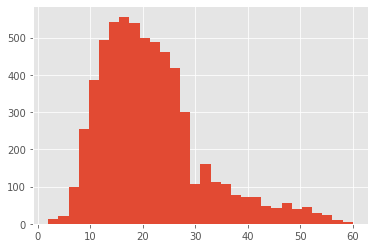

In [ ]:
#get length of all mthe messages in the train set
train_text = X_train
valid_text = X_valid
test_text = X_test
seq_len= [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins=30)
print('sentence with max length: ',max(seq_len))

In [ ]:
max_seq_len = 60

In [ ]:
def tok(dat,maxSeqLen=10,pad='max_length',trunc=True,retTokId=False):
  tt = tokenizer.batch_encode_plus(
    dat.tolist(),
    max_length = maxSeqLen,
    padding = 'max_length', # options are True, 'max_length' or 'longest'
    truncation=trunc,
    return_token_type_ids=retTokId)
  return tt

tokens_train = tok(train_text,maxSeqLen=max_seq_len,pad='max_length',trunc=True,retTokId=False)
tokens_valid = tok(valid_text,maxSeqLen=max_seq_len,pad='max_length',trunc=True,retTokId=False)
tokens_test = tok(test_text,maxSeqLen=max_seq_len,pad='max_length',trunc=True,retTokId=False)



In [ ]:
tokens_train

## transform data objects to tensors

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

valid_seq = torch.tensor(tokens_valid['input_ids'])
valid_mask = torch.tensor(tokens_valid['attention_mask'])
valid_y = torch.tensor(y_valid.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

weights = torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_seq,train_mask,train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

valid_data = TensorDataset(valid_seq,valid_mask,valid_y)
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data,sampler = valid_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq,test_mask,test_y)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data,sampler = test_sampler, batch_size = batch_size)

## freeze BERT parameters

In [ ]:
for param in bert.parameters():
  param.requires_grad = False

 ## define model architecture, loss and optimizer

In [ ]:
class BERT_Arch(nn.Module):
  def __init__(self,bert):
    super(BERT_Arch,self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768,512)
    self.fc2 = nn.Linear(512,2)
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self,sent_id,mask):
    _,cls_hs = self.bert(sent_id,attention_mask=mask)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.softmax(x)
    return x

In [ ]:
model = BERT_Arch(bert)
model = model.to(device)

cross_entropy = nn.NLLLoss(weight = weights)

In [ ]:
optimizer = AdamW(model.parameters(), lr = 0.01)

## fine-tune BERT

In [ ]:
def train():
  model.train()
  total_loss,total_accuracy = 0,0
  total_preds=[]

  for step, batch in enumerate(train_dataloader):
    if step %50 == 0 and not step == 0:
      print(' Batch{:>5,} of {:>5,}.'.format(step,len(train_dataloader))) #print only every 50 batches
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch #from each of the dataloader batches, extract the vector, mask, and lables
    model.zero_grad() # reset previous calculated gradients
    preds = model(sent_id,mask) #predict for sentence and mask
    loss = cross_entropy(preds,labels) # calculate loss
    total_loss = total_loss + loss.item() #add to total loss
    loss.backward() # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(),1) # avoid exploding gradient problem
    optimizer.step() # update parameters
    preds = preds.detach().cpu().numpy() # push model preds to cpu
    total_preds.append(preds) # append model predictions
  avg_loss = total_loss / len(train_dataloader) # compute training loss of the epoch
  total_preds = np.concatenate(total_preds,axis=0) # 
  return avg_loss, total_preds



In [ ]:
def evaluate():
  print("\tevaluating...")
  model.eval() # deactivate droput layers
  total_loss, total_accuracy = 0,0
  total_preds = []
  for step, batch in enumerate(valid_dataloader):
    if step%50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print(' Batch{:>5,} of {:>5,}.'.format(step,len(valid_dataloader))) #print only every 50 batches
    batch = [t.to(device) for t in batch]
    sent_id,mask,labels = batch
    with torch.no_grad():
      preds = model(sent_id,mask)
      loss = cross_entropy(preds,labels) # calculate loss
      total_loss = total_loss + loss.item() #add to total loss
      preds = preds.detach().cpu().numpy() # push model preds to cpu
      total_preds.append(preds) # append model predictions
  avg_loss = total_loss / len(valid_dataloader) # compute training loss of the epoch
  total_preds = np.concatenate(total_preds,axis=0) # 
  return avg_loss, total_preds


In [ ]:
epochs = 5

best_valid_loss = float('inf')
train_losses = []
valid_losses=[]

for epoch in range(epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
  train_loss, _ = train()
  
  valid_loss, _ = evaluate()
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),'saved_weights.pt')

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  print(f'\tTraining Loss:{train_loss:.3f}')
  print(f'\tValidation Loss:{valid_loss:.3f}')




 Epoch 1 / 5
 Batch   50 of   190.
 Batch  100 of   190.
 Batch  150 of   190.
	evaluating...
	Training Loss:0.857
	Validation Loss:0.362

 Epoch 2 / 5
 Batch   50 of   190.
 Batch  100 of   190.
 Batch  150 of   190.
	evaluating...
	Training Loss:0.532
	Validation Loss:0.475

 Epoch 3 / 5
 Batch   50 of   190.
 Batch  100 of   190.
 Batch  150 of   190.
	evaluating...
	Training Loss:0.489
	Validation Loss:0.418

 Epoch 4 / 5
 Batch   50 of   190.
 Batch  100 of   190.
 Batch  150 of   190.
	evaluating...
	Training Loss:0.466
	Validation Loss:0.436

 Epoch 5 / 5
 Batch   50 of   190.
 Batch  100 of   190.
 Batch  150 of   190.
	evaluating...
	Training Loss:0.435
	Validation Loss:0.344


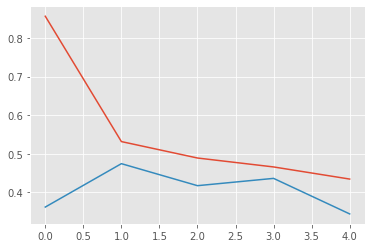

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(train_losses)
ax.plot(valid_losses)
fig.show()

In [ ]:
model.load_state_dict(torch.load('saved_weights.pt'))
with torch.no_grad():
  preds = model(test_seq.to(device),test_mask.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds,axis = 1)
preds


array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
print(classification_report(test_y,preds))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       602
           1       0.92      0.84      0.88       998

    accuracy                           0.85      1600
   macro avg       0.84      0.86      0.85      1600
weighted avg       0.86      0.85      0.86      1600



In [ ]:
pd.crosstab(test_y,preds)

col_0,0,1
row_0,,
0,531,71
1,163,835


In [ ]:
pd.crosstab(test_y,preds)

col_0,0,1
row_0,,
0,531,71
1,163,835


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

tn,fp,fn,tp = confusion_matrix(test_y,preds).ravel()
acc = (tn + tp)/y_test.size
recall = tp/(tp + fn)
fpr = fp/(fp + tn)
prec = tp/(tp + fp)
f1Score = 2*(recall*prec)/(recall + prec)
print("\t-> acc: ",acc)
print("\t-> recall: ",recall)
print("\t-> prec: ",prec)
print("\t-> f1-score: ",f1Score)

	-> acc:  0.85375
	-> recall:  0.8366733466933868
	-> prec:  0.9216335540838853
	-> f1-score:  0.8771008403361346
